# MBA em Ciência de Dados - TCC
# Predição da Radiação Solar para Produção de Hidrogênio Verde: Análise comparativa de métodos de Aprendizado de Máquina

## Modelagem e Predição
**Material Produzido por:** Mateus Vasconcelos Albuquerque

**Cemeai - ICMC/USP São Carlos**


---------------------------------------------------------------------------------------------------------





## **CRISP-DS**

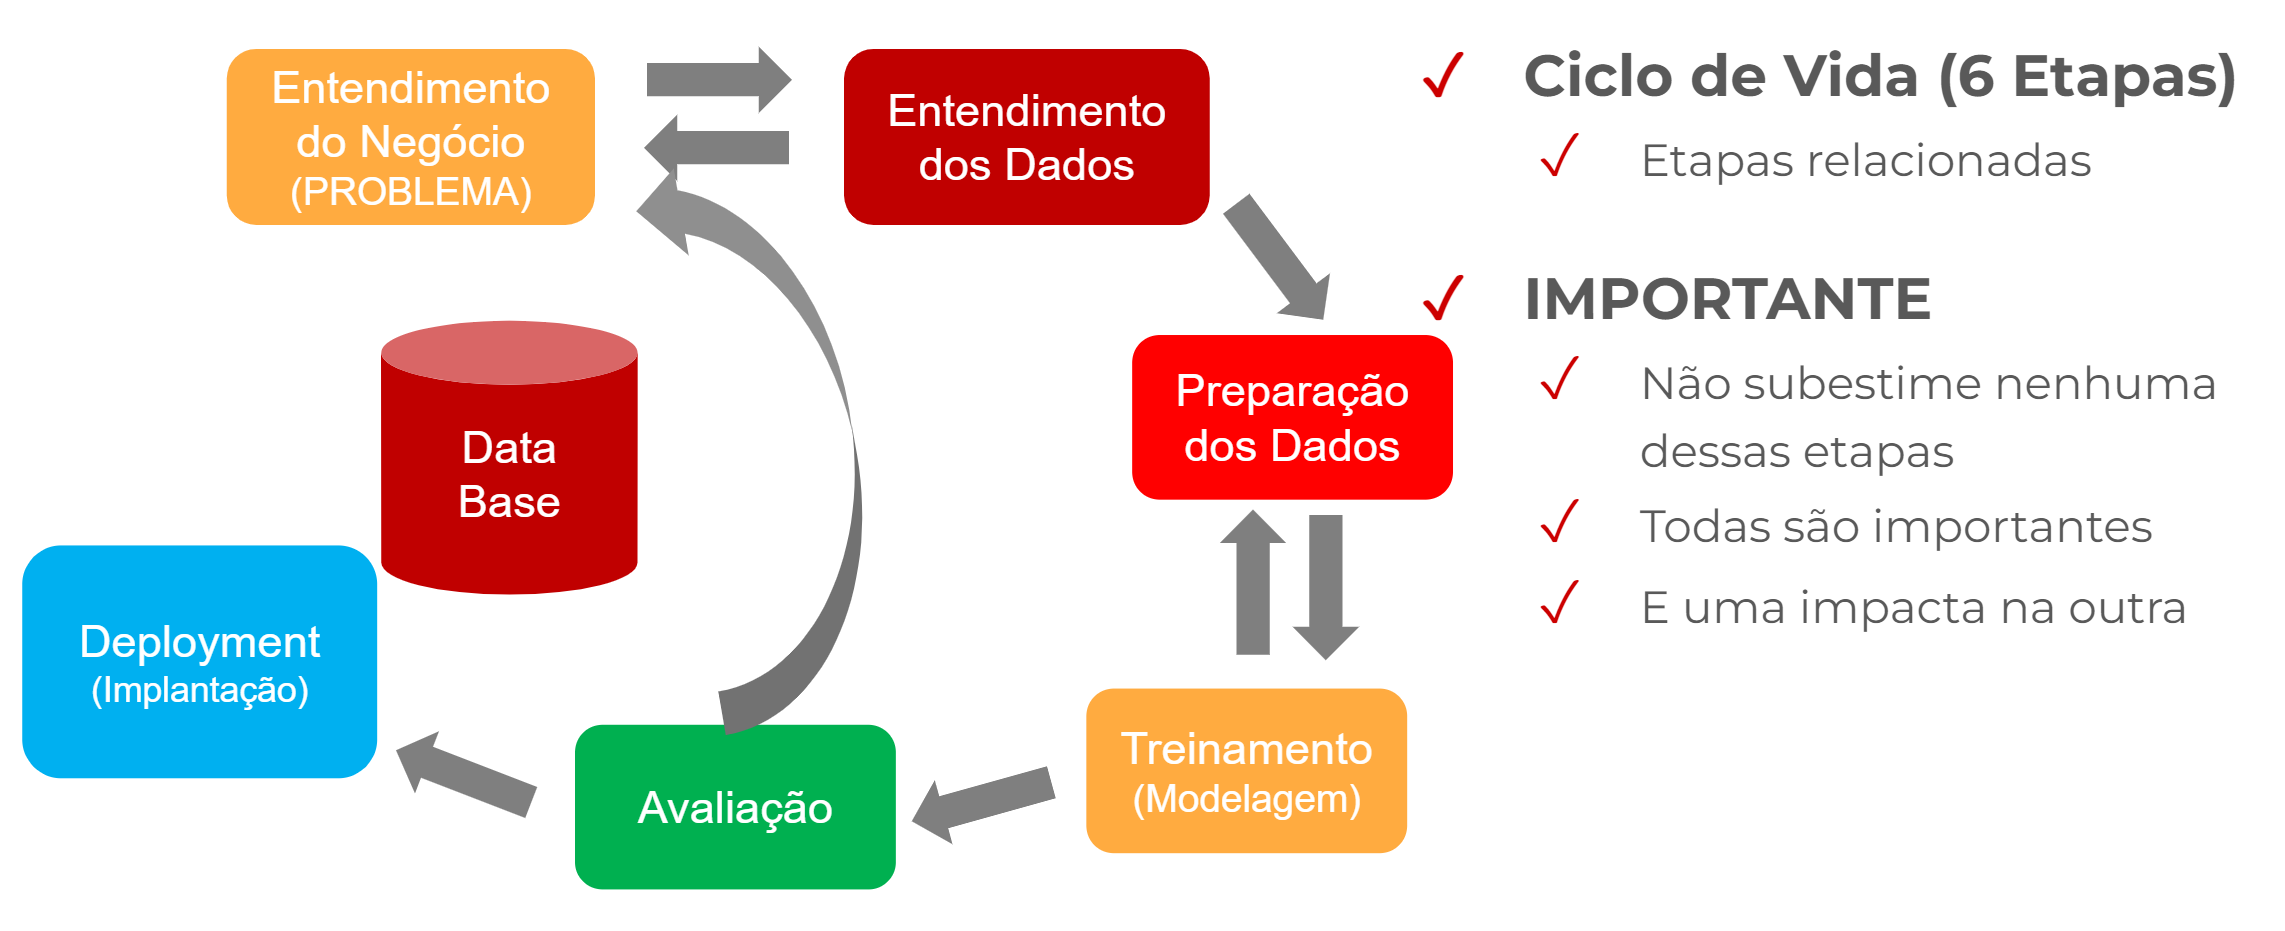

In [3]:
from google.colab import drive
import os

# Monta o Google Drive
drive.mount('/content/drive')

# Define o caminho da pasta 'Projetos'
projetos_path = '/content/drive/My Drive/MBA/TCC/Projeto'

# Define o diretório de trabalho para a pasta 'Projetos'
if os.path.exists(projetos_path):
    os.chdir(projetos_path)
    print(f"Diretório alterado para: {projetos_path}")
else:
    print(f"A pasta 'Projetos' não foi encontrada em: {projetos_path}")

Mounted at /content/drive
Diretório alterado para: /content/drive/My Drive/MBA/TCC/Projeto


## **3. Preparação dos Dados**

### 3.1. Import dos dados pré-processados

In [4]:
import pandas as pd
from pandas.plotting import lag_plot
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import os

In [5]:
# Leitura do arquivo de configuração

# folder para carregar os config files
CONFIG_PATH = "config/"

# Função para carregar os dados
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

In [6]:
config = load_config("data_preprocessing_config_sobral.yaml")

# mostrar todas as colunas
pd.set_option("display.max_columns", None)

In [7]:
# Leitura dos dados a partir do CSV
codigo_wmo = config["input_data_parameters"]["codigo_wmo"]
estacao = config["input_data_parameters"]["estacao"]

input_dir = config["output_directory_preprocessing"]

filepath = f"{input_dir}/preprocessed_data_{codigo_wmo}_{estacao}.csv"

data = pd.read_csv(
    filepath,
    index_col=0,
)

# # remove last 5 columns
# data = data.iloc[:, :-5]

### 3.2. Auto-Regressive Distributed Lag

#### 3.2.1 Time-Delay Embedding

Utilizaremos um método de transformação do problema em um problema de Aprendizado Supervisionado, levando em consideração que o próximo passo a ser predito (t+1) depende dos i valores anteriores da série e de seu valor atual (t-0) bem como os valores atuais e anteriores das variáveis explicativas

https://towardsdatascience.com/machine-learning-for-forecasting-transformations-and-feature-extraction-bbbea9de0ac2
https://towardsdatascience.com/machine-learning-for-forecasting-supervised-learning-with-multivariate-time-series-b5b5044fe068#:~:text=A%20multivariate%20time%20series%20is,predict%20more%20than%20one%20variable.

In [8]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Time delay embedding
    Time series for supervised learning

    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast

    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    X = [series.shift(i) for i in n_lags_iter]
    X = pd.concat(X, axis=1).dropna()
    X.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return X

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43824 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43824 non-null  float64
 3   umidade_relativa_ar_horaria                43824 non-null  float64
 4   vento_direcao_horaria                      43824 non-null  float64
 5   vento_rajada_maxima                        43824 non-null  float64
 6   vento_velocidade_horaria                   43824 non-null  float64
 7   radiacao_global                            43824 non-null  float64
 8   year                                       43824 non-null  int64  
 9   hora                                       43824 non-null  int64  


In [10]:
# create data set with lagged features using time delay embedding
radiation_ds = []
for col in data.iloc[:, :-5]:
    col_df = time_delay_embedding(data[col], n_lags=25, horizon=1)
    radiation_ds.append(col_df)

# concatenating with last 5 columns of data
radiation_ds.append(data.iloc[:, -5:])

# concatenating all variables
radiation_df = pd.concat(radiation_ds, axis=1).dropna()

# remove columns ano, semana e dia_ano
radiation_df = radiation_df.drop(columns=["year", "semana", "dia_ano"])

In [11]:
radiation_df.tail(10)

,precipitacao_total_horario(t-24),precipitacao_total_horario(t-23),precipitacao_total_horario(t-22),precipitacao_total_horario(t-21),precipitacao_total_horario(t-20),precipitacao_total_horario(t-19),precipitacao_total_horario(t-18),precipitacao_total_horario(t-17),precipitacao_total_horario(t-16),precipitacao_total_horario(t-15),precipitacao_total_horario(t-14),precipitacao_total_horario(t-13),precipitacao_total_horario(t-12),precipitacao_total_horario(t-11),precipitacao_total_horario(t-10),precipitacao_total_horario(t-9),precipitacao_total_horario(t-8),precipitacao_total_horario(t-7),precipitacao_total_horario(t-6),precipitacao_total_horario(t-5),precipitacao_total_horario(t-4),precipitacao_total_horario(t-3),precipitacao_total_horario(t-2),precipitacao_total_horario(t-1),precipitacao_total_horario(t-0),precipitacao_total_horario(t+1),pressao_atmosferica_nivel_estacao_horaria(t-24),pressao_atmosferica_nivel_estacao_horaria(t-23),pressao_atmosferica_nivel_estacao_horaria(t-22),pressao_atmosferica_nivel_estacao_horaria(t-21),pressao_atmosferica_nivel_estacao_horaria(t-20),pressao_atmosferica_nivel_estacao_horaria(t-19),pressao_atmosferica_nivel_estacao_horaria(t-18),pressao_atmosferica_nivel_estacao_horaria(t-17),pressao_atmosferica_nivel_estacao_horaria(t-16),pressao_atmosferica_nivel_estacao_horaria(t-15),pressao_atmosferica_nivel_estacao_horaria(t-14),pressao_atmosferica_nivel_estacao_horaria(t-13),pressao_atmosferica_nivel_estacao_horaria(t-12),pressao_atmosferica_nivel_estacao_horaria(t-11),pressao_atmosferica_nivel_estacao_horaria(t-10),pressao_atmosferica_nivel_estacao_horaria(t-9),pressao_atmosferica_nivel_estacao_horaria(t-8),pressao_atmosferica_nivel_estacao_horaria(t-7),pressao_atmosferica_nivel_estacao_horaria(t-6),pressao_atmosferica_nivel_estacao_horaria(t-5),pressao_atmosferica_nivel_estacao_horaria(t-4),pressao_atmosferica_nivel_estacao_horaria(t-3),pressao_atmosferica_nivel_estacao_horaria(t-2),pressao_atmosferica_nivel_estacao_horaria(t-1),pressao_atmosferica_nivel_estacao_horaria(t-0),pressao_atmosferica_nivel_estacao_horaria(t+1),temperatura_ar_bulbo_seco_horaria(t-24),temperatura_ar_bulbo_seco_horaria(t-23),temperatura_ar_bulbo_seco_horaria(t-22),temperatura_ar_bulbo_seco_horaria(t-21),temperatura_ar_bulbo_seco_horaria(t-20),temperatura_ar_bulbo_seco_horaria(t-19),temperatura_ar_bulbo_seco_horaria(t-18),temperatura_ar_bulbo_seco_horaria(t-17),temperatura_ar_bulbo_seco_horaria(t-16),temperatura_ar_bulbo_seco_horaria(t-15),temperatura_ar_bulbo_seco_horaria(t-14),temperatura_ar_bulbo_seco_horaria(t-13),temperatura_ar_bulbo_seco_horaria(t-12),temperatura_ar_bulbo_seco_horaria(t-11),temperatura_ar_bulbo_seco_horaria(t-10),temperatura_ar_bulbo_seco_horaria(t-9),temperatura_ar_bulbo_seco_horaria(t-8),temperatura_ar_bulbo_seco_horaria(t-7),temperatura_ar_bulbo_seco_horaria(t-6),temperatura_ar_bulbo_seco_horaria(t-5),temperatura_ar_bulbo_seco_horaria(t-4),temperatura_ar_bulbo_seco_horaria(t-3),temperatura_ar_bulbo_seco_horaria(t-2),temperatura_ar_bulbo_seco_horaria(t-1),temperatura_ar_bulbo_seco_horaria(t-0),temperatura_ar_bulbo_seco_horaria(t+1),umidade_relativa_ar_horaria(t-24),umidade_relativa_ar_horaria(t-23),umidade_relativa_ar_horaria(t-22),umidade_relativa_ar_horaria(t-21),umidade_relativa_ar_horaria(t-20),umidade_relativa_ar_horaria(t-19),umidade_relativa_ar_horaria(t-18),umidade_relativa_ar_horaria(t-17),umidade_relativa_ar_horaria(t-16),umidade_relativa_ar_horaria(t-15),umidade_relativa_ar_horaria(t-14),umidade_relativa_ar_horaria(t-13),umidade_relativa_ar_horaria(t-12),umidade_relativa_ar_horaria(t-11),umidade_relativa_ar_horaria(t-10),umidade_relativa_ar_horaria(t-9),umidade_relativa_ar_horaria(t-8),umidade_relativa_ar_horaria(t-7),umidade_relativa_ar_horaria(t-6),umidade_relativa_ar_horaria(t-5),umidade_relativa_ar_horaria(t-4),umidade_relativa_ar_horaria(t-3),umidade_relativa_ar_horaria(t-2),umidade_relativa_ar_horaria(t-1),umidade_relativa_ar_horaria(t-0),umidade_relativa_ar_horaria(t+1),vento_direcao

#### 3.2.2 Criação de colunas representando mês e hora

Representaremos como colunas em binário para evitar termos inúmeras colunas via One-Hot Encoding

In [12]:
# One-hot encoding para as variáveis categóricas
radiation_df = pd.get_dummies(radiation_df, columns=["mes", "hora"])

# Remover as colunas originais
# radiation_df = radiation_df.drop(columns=["hora", "mes"])

radiation_df.head()

,precipitacao_total_horario(t-24),precipitacao_total_horario(t-23),precipitacao_total_horario(t-22),precipitacao_total_horario(t-21),precipitacao_total_horario(t-20),precipitacao_total_horario(t-19),precipitacao_total_horario(t-18),precipitacao_total_horario(t-17),precipitacao_total_horario(t-16),precipitacao_total_horario(t-15),precipitacao_total_horario(t-14),precipitacao_total_horario(t-13),precipitacao_total_horario(t-12),precipitacao_total_horario(t-11),precipitacao_total_horario(t-10),precipitacao_total_horario(t-9),precipitacao_total_horario(t-8),precipitacao_total_horario(t-7),precipitacao_total_horario(t-6),precipitacao_total_horario(t-5),precipitacao_total_horario(t-4),precipitacao_total_horario(t-3),precipitacao_total_horario(t-2),precipitacao_total_horario(t-1),precipitacao_total_horario(t-0),precipitacao_total_horario(t+1),pressao_atmosferica_nivel_estacao_horaria(t-24),pressao_atmosferica_nivel_estacao_horaria(t-23),pressao_atmosferica_nivel_estacao_horaria(t-22),pressao_atmosferica_nivel_estacao_horaria(t-21),pressao_atmosferica_nivel_estacao_horaria(t-20),pressao_atmosferica_nivel_estacao_horaria(t-19),pressao_atmosferica_nivel_estacao_horaria(t-18),pressao_atmosferica_nivel_estacao_horaria(t-17),pressao_atmosferica_nivel_estacao_horaria(t-16),pressao_atmosferica_nivel_estacao_horaria(t-15),pressao_atmosferica_nivel_estacao_horaria(t-14),pressao_atmosferica_nivel_estacao_horaria(t-13),pressao_atmosferica_nivel_estacao_horaria(t-12),pressao_atmosferica_nivel_estacao_horaria(t-11),pressao_atmosferica_nivel_estacao_horaria(t-10),pressao_atmosferica_nivel_estacao_horaria(t-9),pressao_atmosferica_nivel_estacao_horaria(t-8),pressao_atmosferica_nivel_estacao_horaria(t-7),pressao_atmosferica_nivel_estacao_horaria(t-6),pressao_atmosferica_nivel_estacao_horaria(t-5),pressao_atmosferica_nivel_estacao_horaria(t-4),pressao_atmosferica_nivel_estacao_horaria(t-3),pressao_atmosferica_nivel_estacao_horaria(t-2),pressao_atmosferica_nivel_estacao_horaria(t-1),pressao_atmosferica_nivel_estacao_horaria(t-0),pressao_atmosferica_nivel_estacao_horaria(t+1),temperatura_ar_bulbo_seco_horaria(t-24),temperatura_ar_bulbo_seco_horaria(t-23),temperatura_ar_bulbo_seco_horaria(t-22),temperatura_ar_bulbo_seco_horaria(t-21),temperatura_ar_bulbo_seco_horaria(t-20),temperatura_ar_bulbo_seco_horaria(t-19),temperatura_ar_bulbo_seco_horaria(t-18),temperatura_ar_bulbo_seco_horaria(t-17),temperatura_ar_bulbo_seco_horaria(t-16),temperatura_ar_bulbo_seco_horaria(t-15),temperatura_ar_bulbo_seco_horaria(t-14),temperatura_ar_bulbo_seco_horaria(t-13),temperatura_ar_bulbo_seco_horaria(t-12),temperatura_ar_bulbo_seco_horaria(t-11),temperatura_ar_bulbo_seco_horaria(t-10),temperatura_ar_bulbo_seco_horaria(t-9),temperatura_ar_bulbo_seco_horaria(t-8),temperatura_ar_bulbo_seco_horaria(t-7),temperatura_ar_bulbo_seco_horaria(t-6),temperatura_ar_bulbo_seco_horaria(t-5),temperatura_ar_bulbo_seco_horaria(t-4),temperatura_ar_bulbo_seco_horaria(t-3),temperatura_ar_bulbo_seco_horaria(t-2),temperatura_ar_bulbo_seco_horaria(t-1),temperatura_ar_bulbo_seco_horaria(t-0),temperatura_ar_bulbo_seco_horaria(t+1),umidade_relativa_ar_horaria(t-24),umidade_relativa_ar_horaria(t-23),umidade_relativa_ar_horaria(t-22),umidade_relativa_ar_horaria(t-21),umidade_relativa_ar_horaria(t-20),umidade_relativa_ar_horaria(t-19),umidade_relativa_ar_horaria(t-18),umidade_relativa_ar_horaria(t-17),umidade_relativa_ar_horaria(t-16),umidade_relativa_ar_horaria(t-15),umidade_relativa_ar_horaria(t-14),umidade_relativa_ar_horaria(t-13),umidade_relativa_ar_horaria(t-12),umidade_relativa_ar_horaria(t-11),umidade_relativa_ar_horaria(t-10),umidade_relativa_ar_horaria(t-9),umidade_relativa_ar_horaria(t-8),umidade_relativa_ar_horaria(t-7),umidade_relativa_ar_horaria(t-6),umidade_relativa_ar_horaria(t-5),umidade_relativa_ar_horaria(t-4),umidade_relativa_ar_horaria(t-3),umidade_relativa_ar_horaria(t-2),umidade_relativa_ar_horaria(t-1),umidade_relativa_ar_horaria(t-0),umidade_relativa_ar_horaria(t+1),vento_direcao

In [13]:
# defining target (Y) and explanatory variables (X)
predictor_variables = radiation_df.columns.str.contains("\(t\-") | radiation_df.columns.str.contains(r"hora_") | radiation_df.columns.str.contains(r"mes_")
target_variables = radiation_df.columns.str.contains("radiacao_global\(t\+")

X = radiation_df.iloc[:, predictor_variables]
Y = radiation_df.iloc[:, target_variables]

#### 3.2.3 Divisão em Treino e Teste

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False)

#### 3.2.4. Min-Max Scaling

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar o Min-Max Scaler
scaler = MinMaxScaler()

# Ajustar o scaler nos dados de treino e transformar os dados de treino
X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_tr), index=X_tr.index, columns=X_tr.columns)

# Transformar os dados de teste (usando o scaler ajustado nos dados de treino)
X_ts_scaled = pd.DataFrame(scaler.transform(X_ts), index=X_ts.index, columns=X_ts.columns)

In [16]:
# Ajustar o scaler nos dados de treino da variável alvo
scaler_y = MinMaxScaler()

# Escalar Y_tr e Y_ts
Y_tr_scaled = pd.DataFrame(scaler_y.fit_transform(Y_tr), index=Y_tr.index, columns=Y_tr.columns)
Y_ts_scaled = pd.DataFrame(scaler_y.transform(Y_ts), index=Y_ts.index, columns=Y_ts.columns)

In [17]:
X_ts_scaled

,precipitacao_total_horario(t-24),precipitacao_total_horario(t-23),precipitacao_total_horario(t-22),precipitacao_total_horario(t-21),precipitacao_total_horario(t-20),precipitacao_total_horario(t-19),precipitacao_total_horario(t-18),precipitacao_total_horario(t-17),precipitacao_total_horario(t-16),precipitacao_total_horario(t-15),precipitacao_total_horario(t-14),precipitacao_total_horario(t-13),precipitacao_total_horario(t-12),precipitacao_total_horario(t-11),precipitacao_total_horario(t-10),precipitacao_total_horario(t-9),precipitacao_total_horario(t-8),precipitacao_total_horario(t-7),precipitacao_total_horario(t-6),precipitacao_total_horario(t-5),precipitacao_total_horario(t-4),precipitacao_total_horario(t-3),precipitacao_total_horario(t-2),precipitacao_total_horario(t-1),precipitacao_total_horario(t-0),pressao_atmosferica_nivel_estacao_horaria(t-24),pressao_atmosferica_nivel_estacao_horaria(t-23),pressao_atmosferica_nivel_estacao_horaria(t-22),pressao_atmosferica_nivel_estacao_horaria(t-21),pressao_atmosferica_nivel_estacao_horaria(t-20),pressao_atmosferica_nivel_estacao_horaria(t-19),pressao_atmosferica_nivel_estacao_horaria(t-18),pressao_atmosferica_nivel_estacao_horaria(t-17),pressao_atmosferica_nivel_estacao_horaria(t-16),pressao_atmosferica_nivel_estacao_horaria(t-15),pressao_atmosferica_nivel_estacao_horaria(t-14),pressao_atmosferica_nivel_estacao_horaria(t-13),pressao_atmosferica_nivel_estacao_horaria(t-12),pressao_atmosferica_nivel_estacao_horaria(t-11),pressao_atmosferica_nivel_estacao_horaria(t-10),pressao_atmosferica_nivel_estacao_horaria(t-9),pressao_atmosferica_nivel_estacao_horaria(t-8),pressao_atmosferica_nivel_estacao_horaria(t-7),pressao_atmosferica_nivel_estacao_horaria(t-6),pressao_atmosferica_nivel_estacao_horaria(t-5),pressao_atmosferica_nivel_estacao_horaria(t-4),pressao_atmosferica_nivel_estacao_horaria(t-3),pressao_atmosferica_nivel_estacao_horaria(t-2),pressao_atmosferica_nivel_estacao_horaria(t-1),pressao_atmosferica_nivel_estacao_horaria(t-0),temperatura_ar_bulbo_seco_horaria(t-24),temperatura_ar_bulbo_seco_horaria(t-23),temperatura_ar_bulbo_seco_horaria(t-22),temperatura_ar_bulbo_seco_horaria(t-21),temperatura_ar_bulbo_seco_horaria(t-20),temperatura_ar_bulbo_seco_horaria(t-19),temperatura_ar_bulbo_seco_horaria(t-18),temperatura_ar_bulbo_seco_horaria(t-17),temperatura_ar_bulbo_seco_horaria(t-16),temperatura_ar_bulbo_seco_horaria(t-15),temperatura_ar_bulbo_seco_horaria(t-14),temperatura_ar_bulbo_seco_horaria(t-13),temperatura_ar_bulbo_seco_horaria(t-12),temperatura_ar_bulbo_seco_horaria(t-11),temperatura_ar_bulbo_seco_horaria(t-10),temperatura_ar_bulbo_seco_horaria(t-9),temperatura_ar_bulbo_seco_horaria(t-8),temperatura_ar_bulbo_seco_horaria(t-7),temperatura_ar_bulbo_seco_horaria(t-6),temperatura_ar_bulbo_seco_horaria(t-5),temperatura_ar_bulbo_seco_horaria(t-4),temperatura_ar_bulbo_seco_horaria(t-3),temperatura_ar_bulbo_seco_horaria(t-2),temperatura_ar_bulbo_seco_horaria(t-1),temperatura_ar_bulbo_seco_horaria(t-0),umidade_relativa_ar_horaria(t-24),umidade_relativa_ar_horaria(t-23),umidade_relativa_ar_horaria(t-22),umidade_relativa_ar_horaria(t-21),umidade_relativa_ar_horaria(t-20),umidade_relativa_ar_horaria(t-19),umidade_relativa_ar_horaria(t-18),umidade_relativa_ar_horaria(t-17),umidade_relativa_ar_horaria(t-16),umidade_relativa_ar_horaria(t-15),umidade_relativa_ar_horaria(t-14),umidade_relativa_ar_horaria(t-13),umidade_relativa_ar_horaria(t-12),umidade_relativa_ar_horaria(t-11),umidade_relativa_ar_horaria(t-10),umidade_relativa_ar_horaria(t-9),umidade_relativa_ar_horaria(t-8),umidade_relativa_ar_horaria(t-7),umidade_relativa_ar_horaria(t-6),umidade_relativa_ar_horaria(t-5),umidade_relativa_ar_horaria(t-4),umidade_relativa_ar_horaria(t-3),umidade_relativa_ar_horaria(t-2),umidade_relativa_ar_horaria(t-1),umidade_relativa_ar_horaria(t-0),vento_direcao_horaria(t-24),vento_direcao_horaria(t-23),vento_direcao_horaria(t-22),vento_direcao_horaria(t-21),vento_direcao_horaria(t-20),vento_direcao_horaria(t-

## **4. Treinamento (Modelagem)**

In [113]:
# fitting a RF model
model = RandomForestRegressor()
model.fit(X_tr_scaled, Y_tr_scaled.to_numpy().ravel())

RandomForestRegressor()

In [114]:
# from joblib import dump

# # Salvar o modelo treinado em um arquivo
# dump(model, "random_forest_model.joblib")

# print("Modelo salvo como 'random_forest_model.joblib'.")

Modelo salvo como 'random_forest_model.joblib'.


In [18]:
# from joblib import load

# # Carregar o modelo salvo
# model = load("random_forest_model.joblib")

# print("Modelo carregado com sucesso.")

Modelo carregado com sucesso.


### 4.1. Treino e Predição de modelo base (RF)

In [19]:
# getting forecasts for the test set
preds = model.predict(X_ts_scaled)

In [20]:
from sklearn.metrics import mean_absolute_error as mae

In [21]:
# computing MAE error
print(mae(Y_ts_scaled, preds))

0.03199597104307796


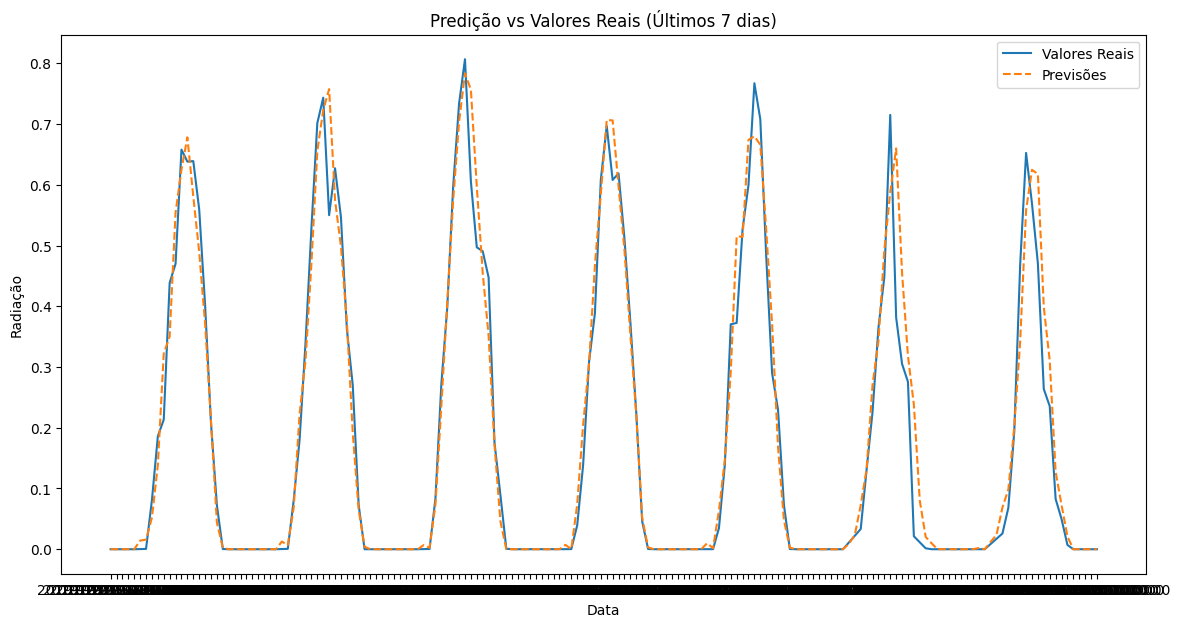

In [22]:
# Selecionando os últimos 7 * 24 valores para visualização
last_values = 7 * 24
Y_ts_last = Y_ts_scaled[-last_values:]
preds_last = preds[-last_values:]

# Plotando os últimos valores
plt.figure(figsize=(14, 7))

# Comparando a primeira coluna (ou ajusta conforme a quantidade de targets)
plt.plot(Y_ts_last, label='Valores Reais')
plt.plot(preds_last, label='Previsões', linestyle='--')

plt.title('Predição vs Valores Reais (Últimos 7 dias)')
plt.xlabel('Data')
plt.ylabel('Radiação')
plt.legend()
plt.show()

### 4.2. Feature Selection

In [23]:
# getting importance scores from previous model
importance_scores = pd.Series(dict(zip(X_tr_scaled.columns, model.feature_importances_)))

# getting top n features
n_features = 40
top_n_features = importance_scores.sort_values(ascending=False)[:n_features]
top_n_features_nm = top_n_features.index

X_tr_top = X_tr_scaled[top_n_features_nm]
X_ts_top = X_ts_scaled[top_n_features_nm]

In [94]:
# show top n features
top_n_features

,0
radiacao_global(t-23),0.681611
radiacao_global(t-0),0.157615
radiacao_global(t-12),0.038809
radiacao_global(t-19),0.031577
radiacao_global(t-20),0.010224
radiacao_global(t-7),0.005200
radiacao_global(t-21),0.004754
radiacao_global(t-11),0.004218
radiacao_global(t-18),0.002534
radiacao_global(t-22),0.002373


In [95]:
# re-fitting the model
model_top_features = RandomForestRegressor()
model_top_features.fit(X_tr_top, Y_tr_scaled.to_numpy().ravel())

# getting forecasts for the test set
preds_topf = model_top_features.predict(X_ts_top)

# computing MAE error
print(mae(Y_ts_scaled, preds_topf))

0.03157553536266217


10 features - MAE 140.08

20 features - MAE 132.36

30 features - MAE 131.87

40 features - MAE 131.23

50 features - MAE 131.45

60 features - MAE 132.15

70 features - MAE 131.61

**OBS.:** Ficaremos com 40 features, resultando no menor MAE. Valores acima para fit sem Min-Max Scaling

In [125]:
# from joblib import dump

# # Salvar o modelo treinado em um arquivo
# dump(model_top_features, "random_forest_top_features_model.joblib")

# print("Modelo salvo como 'random_forest_top_features_model.joblib'.")

Modelo salvo como 'random_forest_top_features_model.joblib'.


### 4.3 Comparação de Modelos de ML tradicionais

Serão comparados os modelos default:
1. KNN Regressor
2. SVR
3. Random Forest
4. XGBoost

In [96]:
!pip install xgboost

In [97]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [98]:
# Lista de modelos com parâmetros default
models = {
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor()
}

# Dicionário para armazenar as métricas
metrics_results = {}

In [99]:
# # Função para calcular MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     # Converte para numpy arrays, caso necessário
#     y_true = np.asarray(y_true).flatten()
#     y_pred = np.asarray(y_pred).flatten()

#     # Verifica se os tamanhos são compatíveis
#     if len(y_true) != len(y_pred):
#         raise ValueError(f"y_true e y_pred devem ter o mesmo tamanho! Recebido: {len(y_true)} e {len(y_pred)}.")

#     # Filtra os valores de Y_ts onde y_true != 0
#     non_zero_indices = y_true != 0
#     y_true_non_zero = y_true[non_zero_indices]
#     y_pred_non_zero = y_pred[non_zero_indices]

#     # Calcula o MAPE
#     return np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100

In [100]:
# Loop pelos modelos
for model_name, model in models.items():
    print(f"Treinando {model_name}...")

    # Treinando o modelo
    model.fit(X_tr_top, Y_tr_scaled.to_numpy().ravel())

    # Prevendo no conjunto de teste
    preds = model.predict(X_ts_top)

    # Calculando as métricas
    mae_val = mean_absolute_error(Y_ts_scaled, preds)
    rmse_val = np.sqrt(mean_squared_error(Y_ts_scaled, preds))
    mape_val = mean_absolute_percentage_error(Y_ts_scaled, preds)

    # Salvando os resultados no dicionário
    metrics_results[model_name] = {
        "MAE": mae_val,
        "RMSE": rmse_val,
        "MAPE": mape_val,
        "Predictions": preds  # Salvando as predições
    }

    print(f"{model_name} - MAE: {mae_val:.4f}, RMSE: {rmse_val:.4f}, MAPE: {mape_val:.2f}%")

Treinando KNN...
KNN - MAE: 0.0406, RMSE: 0.0769, MAPE: 874179273001.40%
Treinando SVR...
SVR - MAE: 0.0481, RMSE: 0.0699, MAPE: 49380858844917.40%
Treinando Random Forest...
Random Forest - MAE: 0.0316, RMSE: 0.0634, MAPE: 60497538640.71%
Treinando XGBoost...
XGBoost - MAE: 0.0336, RMSE: 0.0660, MAPE: 2161920835584.00%


In [101]:
# Comparação de resultados
print("\nComparação de Modelos:")
for model, metrics in metrics_results.items():
    print(f"{model}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, MAPE={metrics['MAPE']:.2f}%")


Comparação de Modelos:
KNN: MAE=0.0406, RMSE=0.0769, MAPE=874179273001.40%
SVR: MAE=0.0481, RMSE=0.0699, MAPE=49380858844917.40%
Random Forest: MAE=0.0316, RMSE=0.0634, MAPE=60497538640.71%
XGBoost: MAE=0.0336, RMSE=0.0660, MAPE=2161920835584.00%


### 4.4. K-fold cross validation

In [129]:
from sklearn.model_selection import KFold

# Número de folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=False)

# Dicionário para armazenar os resultados
cv_results = {}

# Loop pelos modelos
for model_name, model in models.items():
    print(f"Rodando Cross Validation para {model_name}...")

    # Listas para armazenar as métricas de cada fold
    mae_values, rmse_values, mape_values = [], [], []

    # Loop pelos folds
    for train_index, val_index in kf.split(X_tr_top):
        # Dividindo os dados em treino e validação
        X_train, X_val = X_tr_top.iloc[train_index], X_tr_top.iloc[val_index]
        Y_train, Y_val = Y_tr_scaled.iloc[train_index], Y_tr_scaled.iloc[val_index]

        # Treinando o modelo
        model.fit(X_train, Y_train.to_numpy().ravel())

        # Prevendo no conjunto de validação
        preds = model.predict(X_val)

        # Calculando as métricas
        mae_values.append(mean_absolute_error(Y_val, preds))
        rmse_values.append(np.sqrt(mean_squared_error(Y_val, preds)))
        mape_values.append(mean_absolute_percentage_error(Y_val, preds) * 100)  # MAPE em %

    # Salvando os resultados no dicionário
    cv_results[model_name] = {
        "MAE": mae_values,
        "RMSE": rmse_values,
        "MAPE": mape_values
    }

    print(f"{model_name} - MAE médio: {np.mean(mae_values):.4f}, RMSE médio: {np.mean(rmse_values):.4f}, MAPE médio: {np.mean(mape_values):.2f}%")

Rodando Cross Validation para KNN...
KNN - MAE médio: 0.0421, RMSE médio: 0.0805, MAPE médio: 110950782279488.03%
Rodando Cross Validation para SVR...
SVR - MAE médio: 0.0518, RMSE médio: 0.0749, MAPE médio: 5506392994719060.00%
Rodando Cross Validation para Random Forest...
Random Forest - MAE médio: 0.0329, RMSE médio: 0.0660, MAPE médio: 15632481552111.26%
Rodando Cross Validation para XGBoost...
XGBoost - MAE médio: 0.0355, RMSE médio: 0.0696, MAPE médio: 329241985024000.00%


In [130]:
# Criando DataFrame para análise (opcional)
import pandas as pd
cv_summary = pd.DataFrame({
    model_name: {
        "MAE médio": np.mean(metrics["MAE"]),
        "RMSE médio": np.mean(metrics["RMSE"]),
        "MAPE médio (%)": np.mean(metrics["MAPE"])
    }
    for model_name, metrics in cv_results.items()
}).T

print("\nResumo de Cross Validation:")
print(cv_summary)


Resumo de Cross Validation:
               MAE médio  RMSE médio  MAPE médio (%)
KNN             0.042150    0.080528    1.109508e+14
SVR             0.051813    0.074864    5.506393e+15
Random Forest   0.032944    0.066022    1.563248e+13
XGBoost         0.035541    0.069590    3.292420e+14


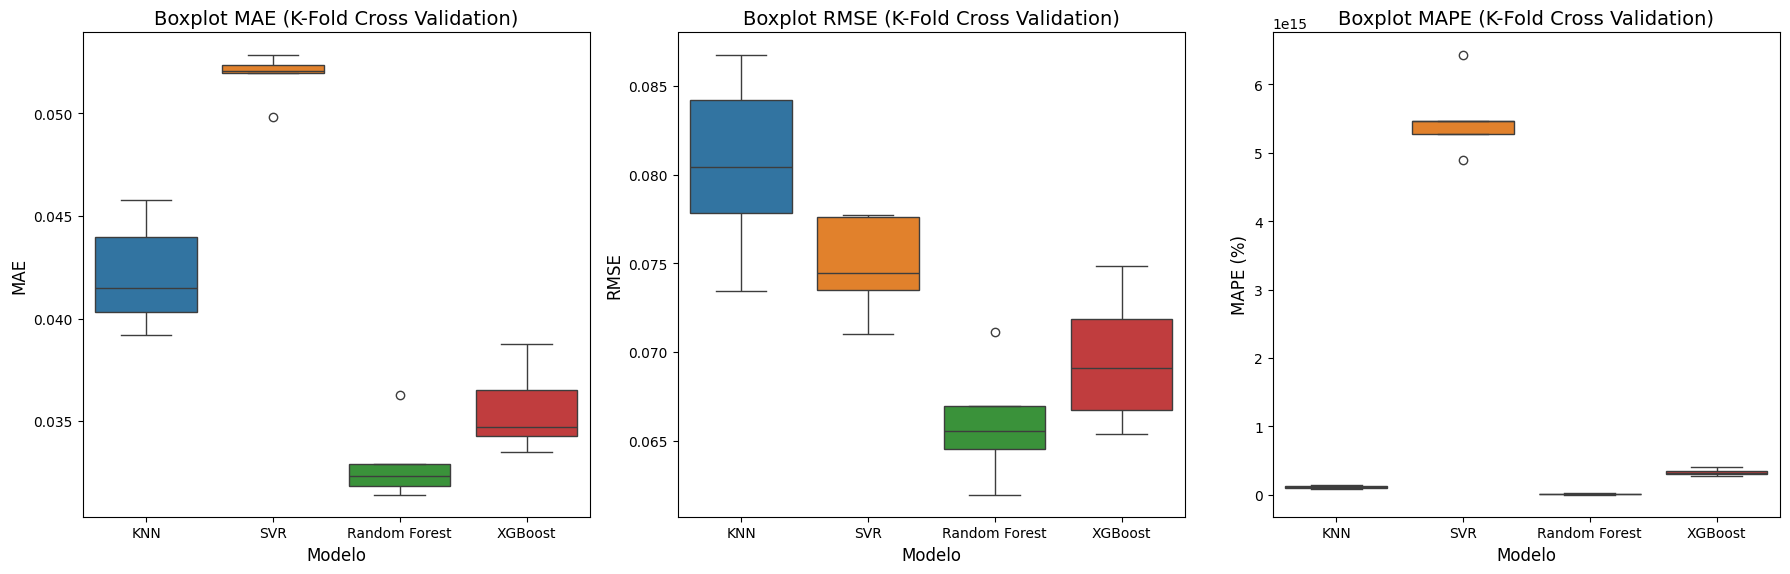

In [131]:
# Preparar dados para o boxplot de cada métrica
mae_data, mse_data, mape_data = [], [], []

for model_name, metrics in cv_results.items():
    for value in metrics["MAE"]:
        mae_data.append({"Modelo": model_name, "Métrica": "MAE", "Valor": value})
    for value in metrics["RMSE"]:
        mse_data.append({"Modelo": model_name, "Métrica": "RMSE", "Valor": value})
    for value in metrics["MAPE"]:
        mape_data.append({"Modelo": model_name, "Métrica": "MAPE", "Valor": value})

# Converter para DataFrames separados por métrica
mae_df = pd.DataFrame(mae_data)
mse_df = pd.DataFrame(mse_data)
mape_df = pd.DataFrame(mape_data)

# Plotando os 3 gráficos separadamente
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot para MAE
sns.boxplot(data=mae_df, x="Modelo", y="Valor", hue="Modelo", ax=axs[0])
axs[0].set_title("Boxplot MAE (K-Fold Cross Validation)", fontsize=14)
axs[0].set_xlabel("Modelo", fontsize=12)
axs[0].set_ylabel("MAE", fontsize=12)

# Boxplot para MSE
sns.boxplot(data=mse_df, x="Modelo", y="Valor", hue="Modelo", ax=axs[1])
axs[1].set_title("Boxplot RMSE (K-Fold Cross Validation)", fontsize=14)
axs[1].set_xlabel("Modelo", fontsize=12)
axs[1].set_ylabel("RMSE", fontsize=12)

# Boxplot para MAPE
sns.boxplot(data=mape_df, x="Modelo", y="Valor", hue="Modelo", ax=axs[2])
axs[2].set_title("Boxplot MAPE (K-Fold Cross Validation)", fontsize=14)
axs[2].set_xlabel("Modelo", fontsize=12)
axs[2].set_ylabel("MAPE (%)", fontsize=12)

# Ajustes finais
plt.tight_layout()
plt.show()

### 4.5. Otimização de Hiperparâmetros

Faremos uma otimização de hiperparâmetros para o melhor modelo segundo as métricas do CrossValidation acima, logo, RandomForest

#### 4.5.1. Estudo de melhores hiperparâmetros com RandomSearch

In [134]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# Definindo os hiperparâmetros e os intervalos
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 50, 100],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ['sqrt', 'log2']
}

# Inicializando o modelo
rf = RandomForestRegressor()

# Configurando TimeSeriesSplit para validação cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o RandomizedSearchCV
random_search_ts = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaçõess a testar
    scoring='neg_mean_absolute_error',  # Métrica de avaliação
    cv=tscv,  # Validação cruzada com 5 folds com TimeSeriesSplit
    verbose=2,
    # n_jobs=2  # Paralelismo
)

# Executando a busca
random_search_ts.fit(X_tr_top, Y_tr_scaled.to_numpy().ravel())

# Exibindo os melhores parâmetros encontrados
print("Melhores parâmetros do RandomizedSearchCV:")
print(random_search_ts.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=20, min_samples_split=15, n_estimators=200; total time=   3.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=20, min_samples_split=15, n_estimators=200; total time=   7.4s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=20, min_samples_split=15, n_estimators=200; total time=  11.7s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=20, min_samples_split=15, n_estimators=200; total time=  16.4s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=20, min_samples_split=15, n_estimators=200; total time=  20.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=20, min_samples_split=2, n_estimators=500; total time=   8.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=20, min_samples_split=2, n_estimators=500; total time=  15.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=20, min_samples_split=2, n_

In [24]:
# Definir os melhores parâmetros encontrados
# best_params_ts = random_search_ts.best_params_
best_params_ts = {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100}

# Instanciar o modelo com os melhores parâmetros
best_rf_ts = RandomForestRegressor(**best_params_ts)

# Fitar o modelo nos dados de treino
best_rf_ts.fit(X_tr_top, Y_tr_scaled.to_numpy().ravel())

RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=1000)

In [25]:
from joblib import dump

# Salvar o modelo treinado em um arquivo
dump(best_rf_ts, "random_forest_random_search_ts_model.joblib")

print("Modelo salvo como 'random_forest_random_search_ts_model.joblib'.")

Modelo salvo como 'random_forest_random_search_ts_model.joblib'.


In [26]:
# Fazer previsões no conjunto de teste
y_pred_ts = best_rf_ts.predict(X_ts_top)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calcular métricas de avaliação
mae_ts = mean_absolute_error(Y_ts_scaled, y_pred_ts)
rmse_ts = np.sqrt(mean_squared_error(Y_ts_scaled, y_pred_ts))
mape_ts = mean_absolute_percentage_error(Y_ts_scaled, y_pred_ts) * 100

# Exibir as métricas
print(f"MAE: {mae_ts}")
print(f"RMSE: {rmse_ts}")
print(f"MAPE: {mape_ts}%")

MAE: 0.03222779779054468
RMSE: 0.06286843576125223
MAPE: 37749701943792.7%


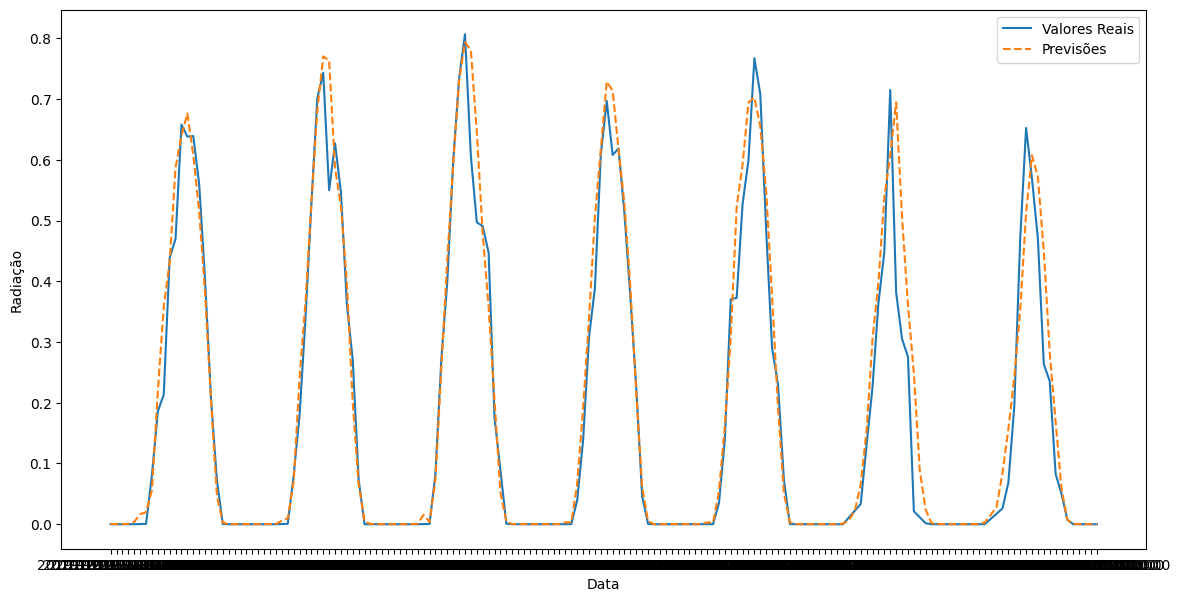

In [29]:
# Selecionando os últimos 7 * 24 valores para visualização
last_values = 7 * 24
Y_ts_last = Y_ts_scaled[-last_values:]
preds_rf_ts_last = y_pred_ts[-last_values:]

# Plotando os últimos valores
plt.figure(figsize=(14, 7))

# Comparando a primeira coluna (ou ajusta conforme a quantidade de targets)
plt.plot(Y_ts_last, label='Valores Reais')
plt.plot(preds_rf_ts_last, label='Previsões', linestyle='--')

# plt.title('Predição vs Valores Reais (Últimos 7 dias)')
plt.xlabel('Data')
plt.ylabel('Radiação')
plt.legend()
plt.show()